In [1]:
import sys
sys.path.append('../../')

from amplify.client import FixstarsClient
from matplotlib import pyplot as plt
import numpy as np
import os
import tikzplotlib

from flow_solver.finite_element_model import FEM
from flow_solver.mesh_generator import MeshDoublePipe
from optimizer import Annealing, AnnealingSolver, PolyTop
from problems.topo_opt_level_set_fluid_flow import TopologyOptimizationProblem

# Topology Optimization for Double Pipe Problem

In [2]:
output_path = '/usr2/key/Projects/QuantumAnnealing/TopoFlowManuscript/fig/comparison/double_pipe'

## Computational Mesh

In [3]:
# Create Meshes for double pipe problem.
n_elem_for_width = 48
n_elem_for_height = 32
mesh_v = MeshDoublePipe('Q2', n_elem_for_width, n_elem_for_height, width=1.5, height=1.0, inlet_height=1./6., outlet_height=1./6.)
mesh_p = MeshDoublePipe('Q1', n_elem_for_width, n_elem_for_height, width=1.5, height=1.0, inlet_height=1./6., outlet_height=1./6.)

## Finite Element Model

### Boundary Conditions

In [4]:
def upper_inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 1-144*((y-3/4)**2); v_y = 0.0
    return np.array([v_x, v_y])

In [5]:
def lower_inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 1-144*((y-1/4)**2); v_y = 0.0
    return np.array([v_x,v_y])

In [6]:
# Compute boundary velocities.
boundary_velocity = {key: [] for key in mesh_v.boundary_nodes.keys()}
for boundary in mesh_v.boundary_nodes.keys():
    for i_node in mesh_v.boundary_nodes[boundary]:
        if boundary == 'inlet_upper':
            boundary_velocity[boundary].append(upper_inlet_velocity(mesh_v, i_node))
        elif boundary == 'inlet_lower':
            boundary_velocity[boundary].append(lower_inlet_velocity(mesh_v, i_node))
        elif boundary == 'wall':
            boundary_velocity[boundary].append(np.zeros(2))
        if boundary == 'outlet_upper':
            boundary_velocity[boundary].append(upper_inlet_velocity(mesh_v, i_node))
        elif boundary == 'outlet_lower':
            boundary_velocity[boundary].append(lower_inlet_velocity(mesh_v, i_node))

# Set values for Dirichlet boundary conditions.
# Velocity.
BC = []
for boundary in mesh_v.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_v.boundary_nodes[boundary]):
        if (boundary == 'inlet_upper' or 
            boundary == 'inlet_lower' or 
            boundary == 'wall' or 
            boundary == 'outlet_upper' or 
            boundary == 'outlet_lower'):
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]])
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
boundary_values_v = np.array(BC)

### Material Properties

In [24]:
viscosity = 1. 
density = 1.

# 
epsilon = 8.e-2

alpha_bar = viscosity/epsilon
print(alpha_bar)

12.5


### Finite Element Model

In [8]:
fem = FEM(mesh_v, mesh_p, viscosity, density, epsilon)
fem.set_boudary_values_v(boundary_values_v)

Objective Function:0.001291177124467389


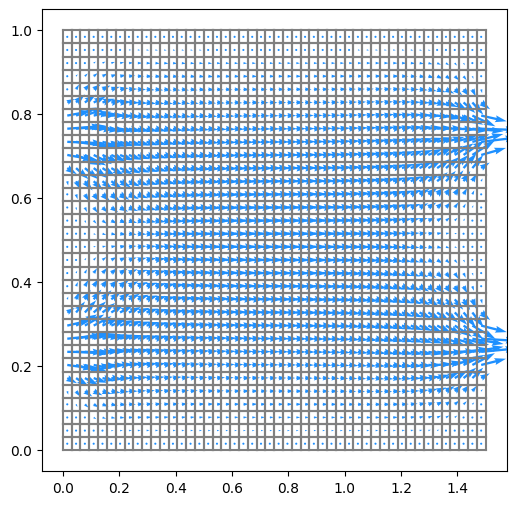

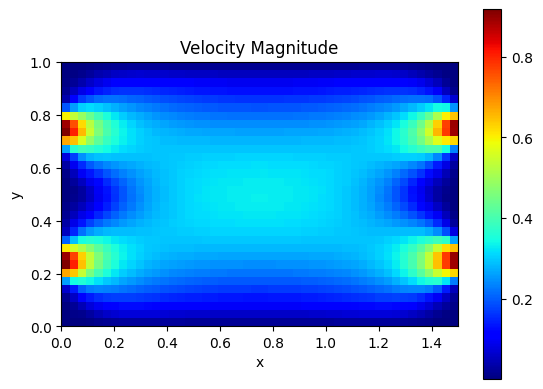

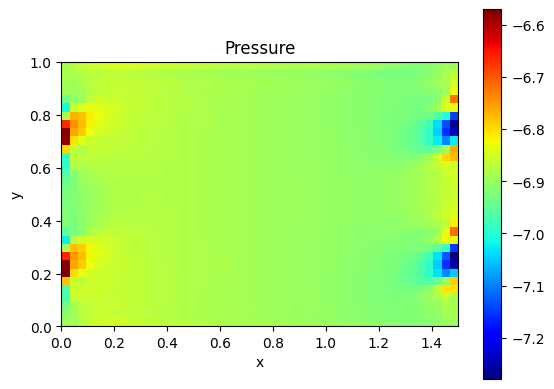

In [9]:
U, u_e, v_e, p_e, F, f=fem.solve()
objective_initial = F
volume_fraction_initial = 1.0
print(f'Objective Function:{f}')
fem.plot_velocity_field([u_e, v_e])
fem.plot_velocity_magnitude([u_e, v_e])
fem.plot_pressure(p_e)

## Optimization

In [10]:
# Settings for Optimization.
volume_fraction_max = 1./3. # Volume fraction.
design_tolerance = 0.01 # Convergence tolerance on design variables.

active = {'classic': True,
          'annealing': True}

### Classical Optimization

In [11]:
density_initial = np.ones(mesh_v.n_elem) # Initial density, i.e., design variables, for each element.
density_min = 0.0; density_max = 1.0 # Lower and upper bound for design variables.

max_iterations = 150 # Max. number of optimization steps.

opt_OCMove = 0.2  # Allowable move step in OC update scheme
opt_OCEta = 0.5  # Exponent used in OC update scheme

q_values =  10. ** -np.arange(4, -1, -1)

############## q = 0.0001 ##############
Iteration: 1, Objective Function: 0.001291177124467389, Volume Fraction: 0.7999999999999999
1.0
Iteration: 2, Objective Function: 0.001308004134037117, Volume Fraction: 0.6
0.013032301495171905
Iteration: 3, Objective Function: 0.0013359902370118693, Volume Fraction: 0.4000000000000001
0.021396035567849418
Iteration: 4, Objective Function: 0.0013917538336917755, Volume Fraction: 0.3251666956973057
0.04173952408861106
Iteration: 5, Objective Function: 0.0013897537807040477, Volume Fraction: 0.33927887999537126
0.0014370738124158053


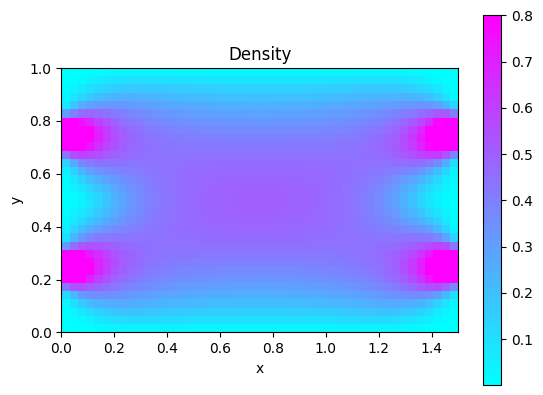

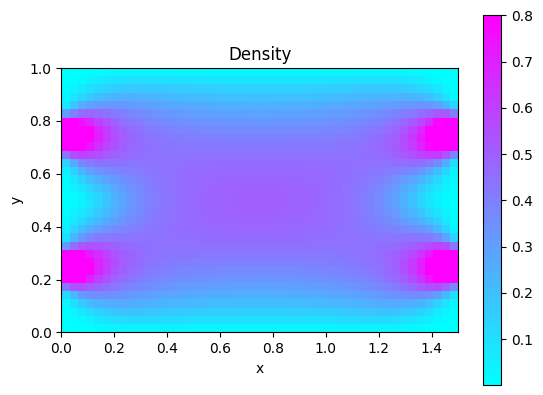

############## q = 0.001 ###############
Iteration: 1, Objective Function: 0.002067381092455548, Volume Fraction: 0.3351205941154684
0.48758803261410455
Iteration: 2, Objective Function: 0.0020647445926770622, Volume Fraction: 0.33498980141760387
0.0012752848461791363


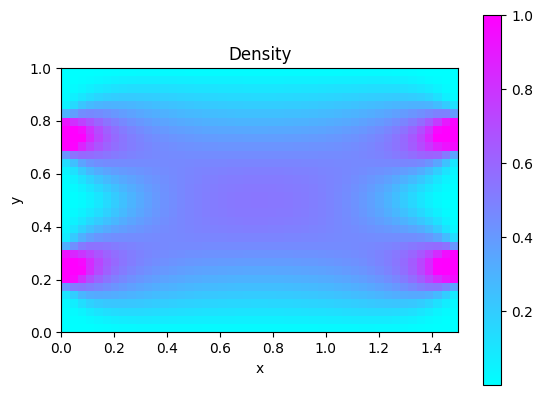

############### q = 0.01 ###############
Iteration: 1, Objective Function: 0.008265813511033357, Volume Fraction: 0.3333273445622705
3.0033104047587047
Iteration: 2, Objective Function: 0.007921000238180856, Volume Fraction: 0.33353051909451853
0.04171558823487095
Iteration: 3, Objective Function: 0.007542358621352571, Volume Fraction: 0.3331710968741232
0.04780224787813471
Iteration: 4, Objective Function: 0.007189972093007689, Volume Fraction: 0.3333417749494935
0.04672099883281444
Iteration: 5, Objective Function: 0.006801104173554528, Volume Fraction: 0.33314871686110425
0.05408476061142697


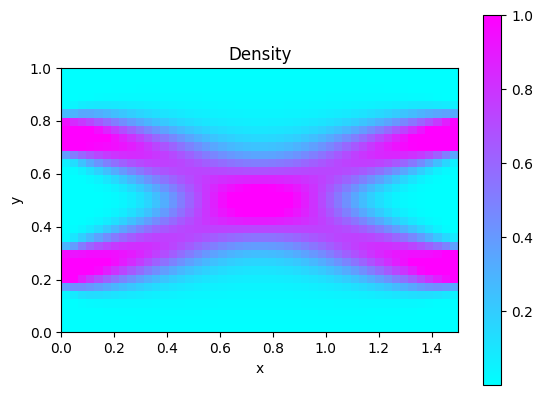

Iteration: 6, Objective Function: 0.006409177422759535, Volume Fraction: 0.33347255148702826
0.05762692950932354
Iteration: 7, Objective Function: 0.006052432838773558, Volume Fraction: 0.33343696732433364
0.055661524163638586
Iteration: 8, Objective Function: 0.005801641456075273, Volume Fraction: 0.3334691216629868
0.04143645859093994
Iteration: 9, Objective Function: 0.005629772653716941, Volume Fraction: 0.33318481662938154
0.02962416820473405
Iteration: 10, Objective Function: 0.005526299650121492, Volume Fraction: 0.33344222376625937
0.01837960606226833


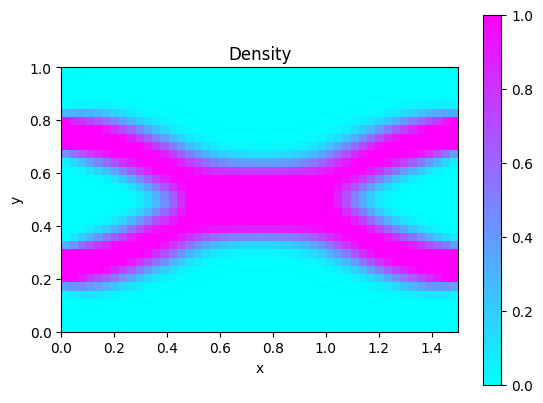

Iteration: 11, Objective Function: 0.005437732581632635, Volume Fraction: 0.3334605114338713
0.016026468721599303
Iteration: 12, Objective Function: 0.005378629764643349, Volume Fraction: 0.33344083680875464
0.010869018676814205
Iteration: 13, Objective Function: 0.005332535423412344, Volume Fraction: 0.3333393681230832
0.008569904092304022


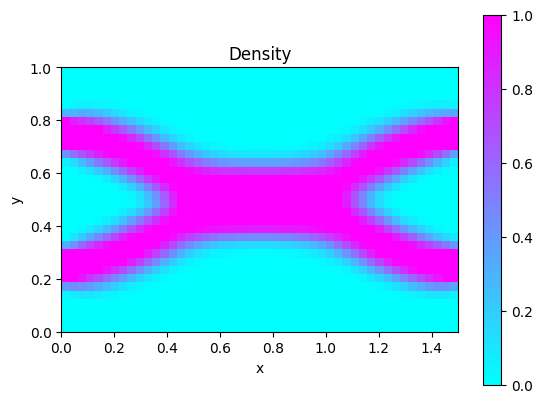

############### q = 0.1 ################
Iteration: 1, Objective Function: 0.012593551995900088, Volume Fraction: 0.3333260110728466
1.3616443203749682
Iteration: 2, Objective Function: 0.009513737466044381, Volume Fraction: 0.3333324910511019
0.24455487465794876
Iteration: 3, Objective Function: 0.008877279050627488, Volume Fraction: 0.3333255832630922
0.0668988836078866
Iteration: 4, Objective Function: 0.008720374462198121, Volume Fraction: 0.33333954661336546
0.01767485144203914
Iteration: 5, Objective Function: 0.008647507215201963, Volume Fraction: 0.3333279641622883
0.008355976834713955


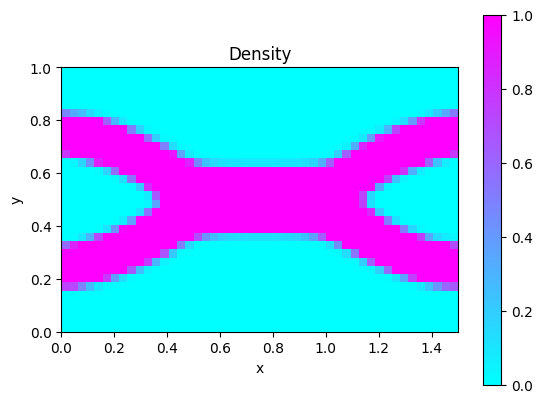

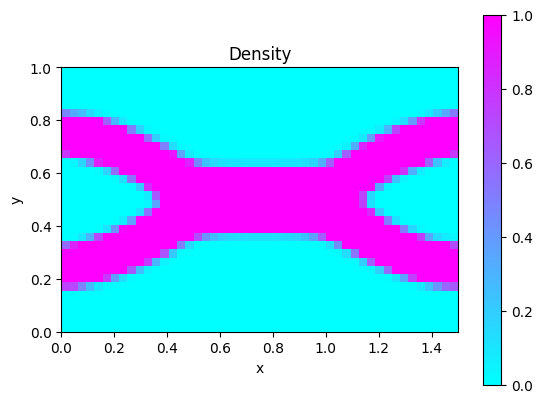

############### q = 1.0 ################
Iteration: 1, Objective Function: 0.01086862857115451, Volume Fraction: 0.3333293733306541
0.2568510555328486
Iteration: 2, Objective Function: 0.010109532909712322, Volume Fraction: 0.333337339604501
0.06984281930995775
Iteration: 3, Objective Function: 0.009762729460338447, Volume Fraction: 0.3333351137410616
0.03430459670799403
Iteration: 4, Objective Function: 0.00961873874934866, Volume Fraction: 0.3333319781232879
0.014749021938460661
Iteration: 5, Objective Function: 0.009554308273381612, Volume Fraction: 0.3333308244253877
0.006698432886682854


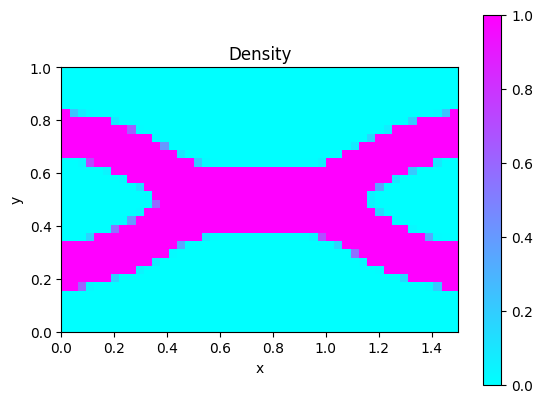

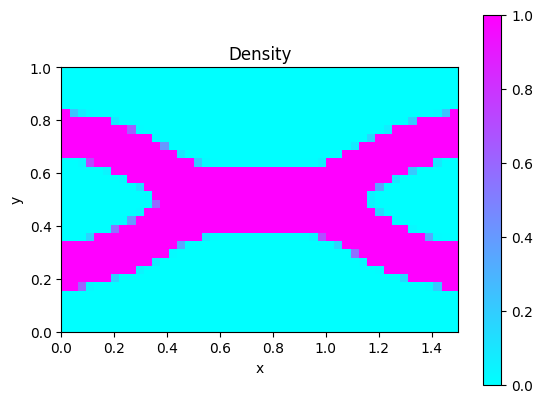

Final objective function (binary design): 0.00998718787665346, volume fraction 0.3268229166666667


In [12]:
poly_top = PolyTop(fem)
if active['classic']:
    density = poly_top.optimize(density_initial, density_min, density_max, volume_fraction_max,
                    design_tolerance, max_iterations, q_values,
                    opt_OCMove, opt_OCEta)
    
    binary_array = np.where(density >= 0.95, 1, 0)
    E = fem.viscosity/fem.epsilon*(1-binary_array)
    _, u, v, _, _, f = fem.solve(E)
    print(f'Final objective function (binary design): {f}, volume fraction {sum(binary_array)/mesh_p.area}')

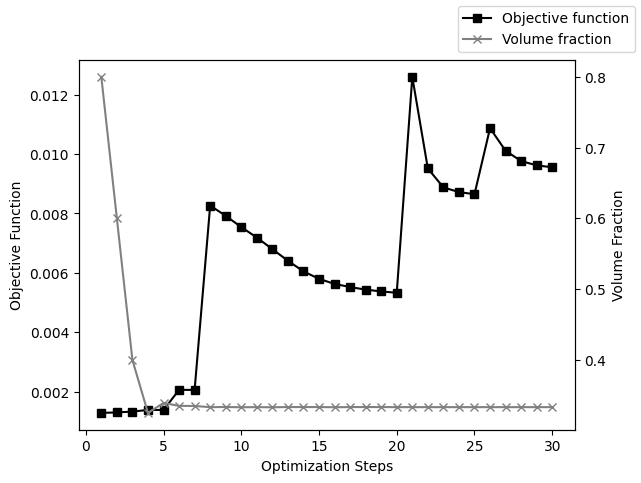

In [ ]:
if active['classic']:
    poly_top.plot_history()

### Optimization with Ising Machine Formulation

In [14]:
# Annealing Solver.
client = FixstarsClient()
client.parameters.timeout = 10000
client.parameters.outputs.duplicate = True
if os.path.exists('token_Fixstars.txt'):
    client.token = open('token_Fixstars.txt',"r").read().replace('\n', '')
if os.path.exists('proxy.txt'):
    client.proxy = open('proxy.txt',"r").read().replace('\n', '')

annealing_solver = AnnealingSolver(client)

In [15]:
# Topology Optimization Problem in Ising Machine Formulation.
n_qubits_per_variable = 9


hyperparameters = {
        'energy_dissipation': 1.,
        'regularization': 0.,
        'volume_constraint': 0.05,
        'char_func': 0.
}

topo_opt_problem = TopologyOptimizationProblem(fem.ne, n_qubits_per_variable, hyperparameters, volume_fraction_max)
topo_opt_problem.generate_discretizaton()

Iteration: 0, Objective Function: 0.020346737524760867, Volume Fraction: 0.33984375, Inconsistencies: 1014


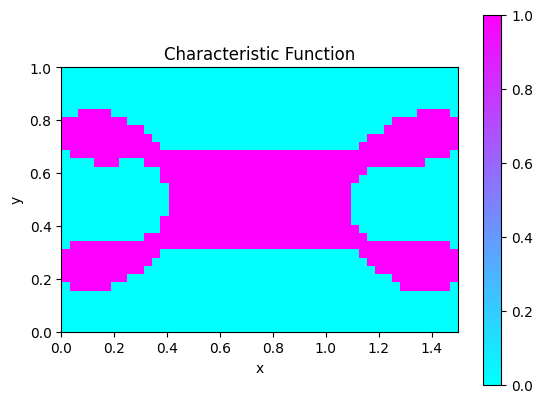

Abs. change in
	char. func.:1014.0
Rel. change in
	char. func.:0.66015625
	Obj. func.: 14.758285319029257


Iteration: 1, Objective Function: 0.014870822288675, Volume Fraction: 0.3352864583333333, Inconsistencies: 1021


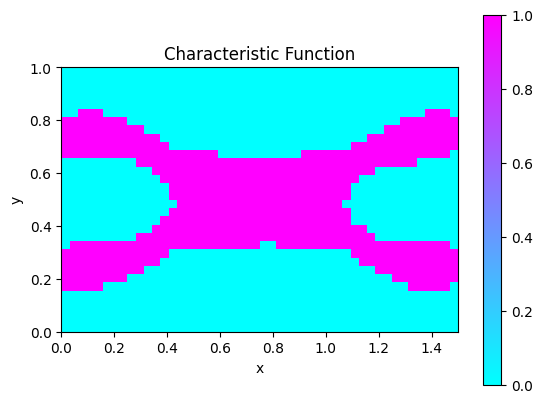

Abs. change in
	char. func.:39.0
Rel. change in
	char. func.:0.07471264367816093
	Obj. func.: 0.2691298902058366
Iteration: 2, Objective Function: 0.013405506524029633, Volume Fraction: 0.3346354166666667, Inconsistencies: 1022


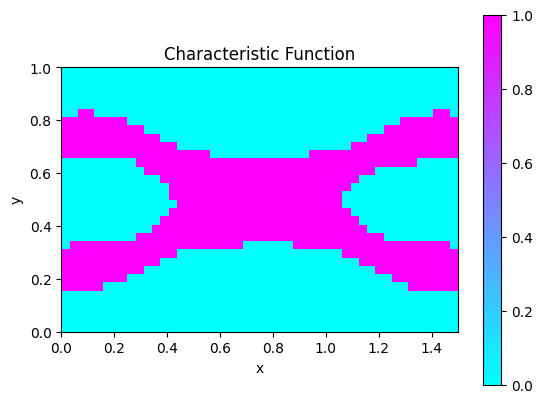

Abs. change in
	char. func.:17.0
Rel. change in
	char. func.:0.03300970873786408
	Obj. func.: 0.09853629720000687
Iteration: 3, Objective Function: 0.012687255415105835, Volume Fraction: 0.3346354166666667, Inconsistencies: 1022


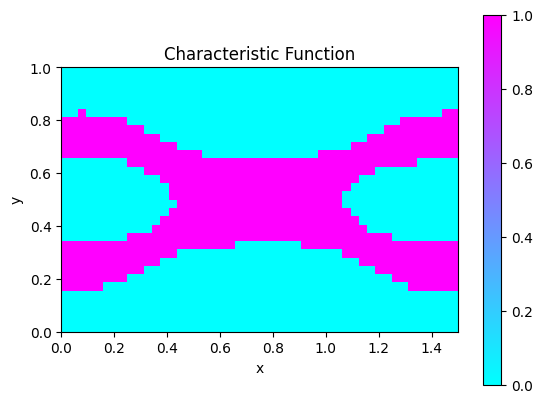

Abs. change in
	char. func.:12.0
Rel. change in
	char. func.:0.023346303501945526
	Obj. func.: 0.05357881163507841
Iteration: 4, Objective Function: 0.012229017179095612, Volume Fraction: 0.3346354166666667, Inconsistencies: 1022


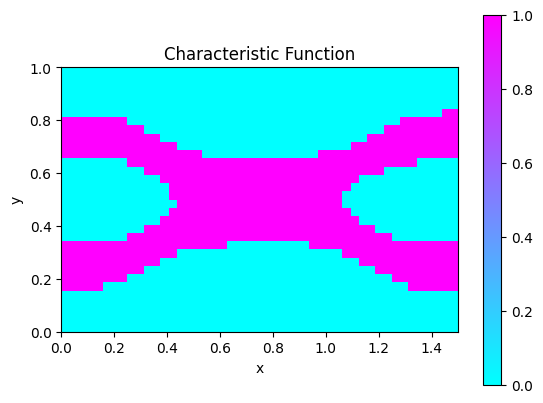

Abs. change in
	char. func.:6.0
Rel. change in
	char. func.:0.011673151750972763
	Obj. func.: 0.0361179956592212
Iteration: 5, Objective Function: 0.012089643167481528, Volume Fraction: 0.3346354166666667, Inconsistencies: 1022


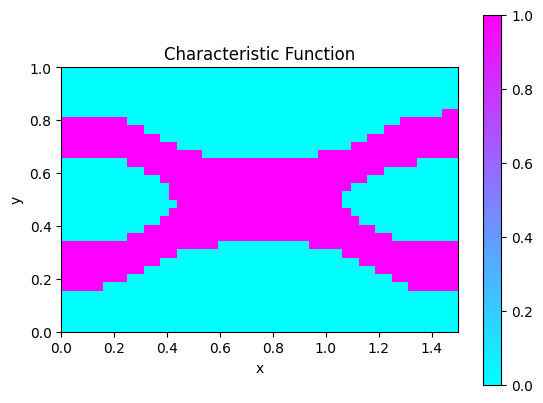

Abs. change in
	char. func.:2.0
Rel. change in
	char. func.:0.0038910505836575876
	Obj. func.: 0.011396992053648533
Iteration: 6, Objective Function: 0.011983384937854957, Volume Fraction: 0.3346354166666667, Inconsistencies: 1022


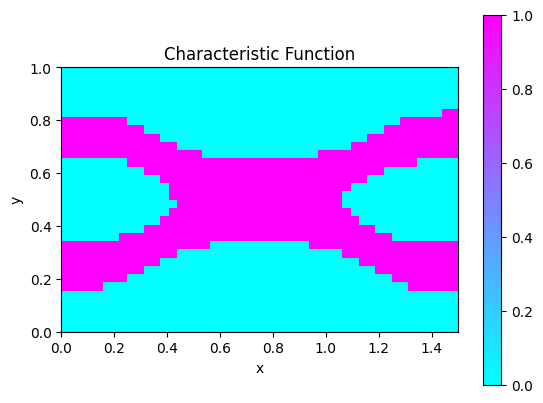

Abs. change in
	char. func.:2.0
Rel. change in
	char. func.:0.0038910505836575876
	Obj. func.: 0.008789194863284479


In [16]:
# Optimization
max_opt_steps = 15
# Initial scaled level-set values, i.e., design variables, for each element.
level_set_scaled_initial = np.ones(mesh_v.n_elem) 
annealing_optimizer = Annealing(fem)
if active['annealing']:
    char_func = annealing_optimizer.optimize(annealing_solver,
                                topo_opt_problem, 
                                level_set_scaled_initial,
                                max_opt_steps,
                                design_tolerance,
                                plot_steps=True)

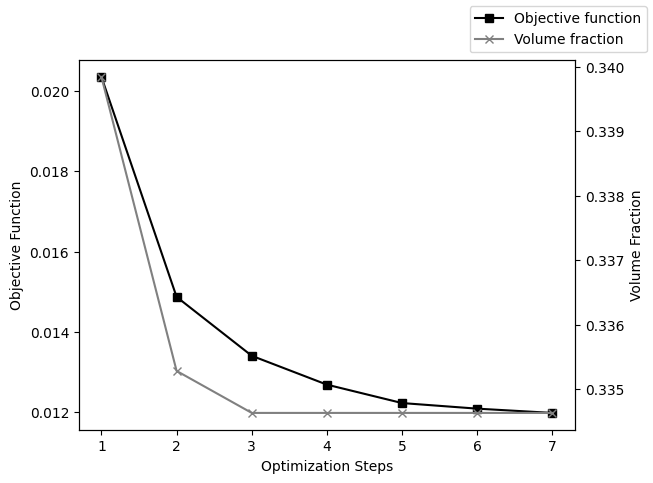

In [17]:
if active['annealing']:
    annealing_optimizer.plot_history()

In [18]:
binary_array = np.where(density >= 0.95, 1, 0)
E = fem.viscosity/fem.epsilon*(1-binary_array)
_, u, v, _, _, f = fem.solve(E)
print(f'Final objective function (binary design): {f}, volume fraction {sum(binary_array)/mesh_p.area}')

Final objective function (binary design): 0.00998718787665346, volume fraction 0.3268229166666667


In [19]:
print((f-annealing_optimizer.objective_function)/f)

-0.1998757894469879


In [23]:
# Comparison
# Number of optimization steps
n_C = len(poly_top.objective_function_list)
n_A = len(annealing_optimizer.objective_function_list)
print('Number of optimization steps:')
print('\tClassical:', n_C)
print('\tAnnealing:', n_A)
print('\tRel. Diff. (%):', (n_A-n_C)/n_C*100)
# Objective function
print('Objective function:')
print('\tClassical: '+'{:.3e}'.format(f))
print('\tAnnealing: '+'{:.3e}'.format(annealing_optimizer.objective_function))
print('\tRel. Diff (%).:', (annealing_optimizer.objective_function-f)/f*100)

Number of optimization steps:
	Classical: 30
	Annealing: 7
	Rel. Diff. (%): -76.66666666666667
Objective function:
	Classical: 9.987e-03
	Annealing: 1.198e-02
	Rel. Diff (%).: 19.98757894469879


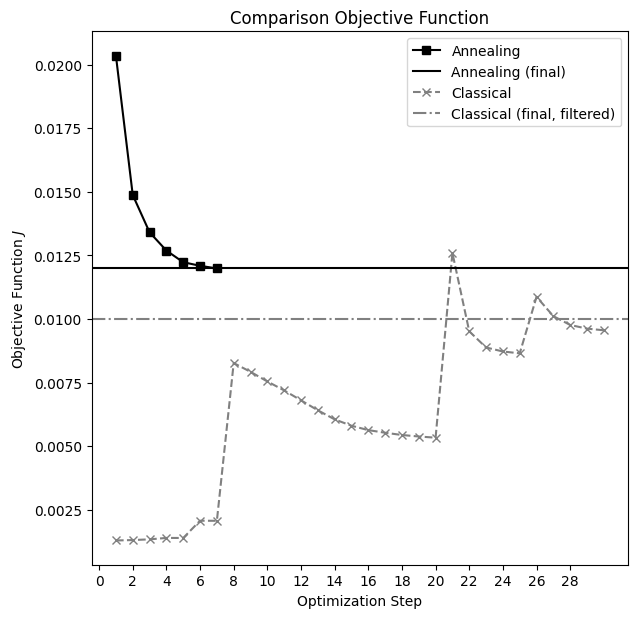

In [ ]:
%matplotlib inline

# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",  # Use pdflatex or xelatex
#     "font.family": "serif",        # Use LaTeX default serif font
#     "text.usetex": True,           # Use LaTeX for all text
#     "pgf.rcfonts": False,          # Don't use matplotlib's rc settings, keep LaTeX's
# })

textwidth_in_inches = 500.484/72.27
aspect_ratio = 1.
fig, ax = plt.subplots(figsize=(textwidth_in_inches, textwidth_in_inches * aspect_ratio))
ax.set_title('Comparison Objective Function')
ax.plot(np.arange(1, len(annealing_optimizer.objective_function_list)+1),annealing_optimizer.objective_function_list,label="Annealing", marker='s', color='k',zorder=2)
ax.axhline(y=annealing_optimizer.objective_function, color='k', label='Annealing (final)', zorder=2)
ax.plot(np.arange(1, len(poly_top.objective_function_list)+1),poly_top.objective_function_list,label="Classical",marker='x',color='gray', linestyle='dashed',zorder=1)
ax.axhline(y=f, color='gray', label='Classical (final, filtered)', linestyle='dashdot',zorder=1)

natural_numbers = np.arange(0, max(len(annealing_optimizer.objective_function_list),len(poly_top.objective_function_list)),2)
plt.xticks(natural_numbers)
ax.set_xlabel('Optimization Step')
ax.set_ylabel(r'Objective Function $J$')
ax.legend(loc='best', fontsize='medium')

fig.show()

tikzplotlib.save(os.path.join(output_path, 'comparison_objective.tex'))


0.0009765625
0.3346354166666667
(-0.4500000000000002, 31.45)


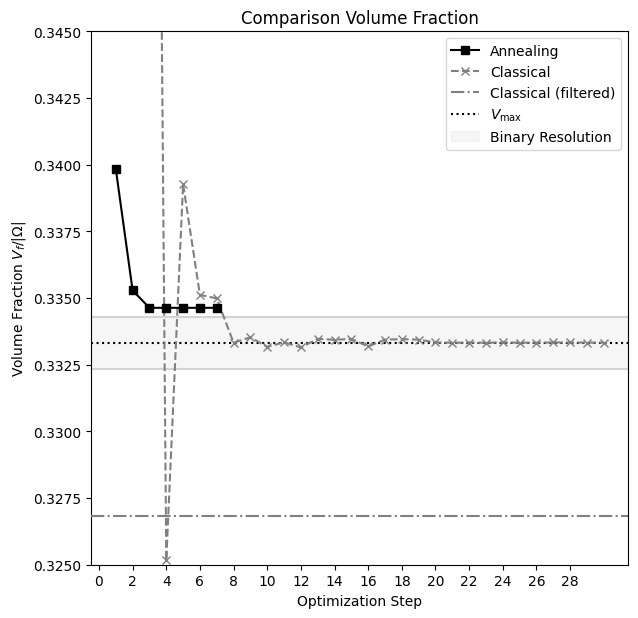

In [ ]:
dV = 1.5/mesh_p.n_elem
print(dV)
print(annealing_optimizer.volume_fraction)
fig, ax = plt.subplots(figsize=(textwidth_in_inches, textwidth_in_inches * aspect_ratio))
ax.set_title('Comparison Volume Fraction')
ax.plot(np.arange(1, len(annealing_optimizer.volume_fraction_list)+1), annealing_optimizer.volume_fraction_list,label='Annealing',marker='s',color='k',zorder=4)
ax.plot(np.arange(1, len(poly_top.volume_fraction_list)+1), poly_top.volume_fraction_list,label='Classical',marker='x',color='gray', linestyle='dashed',zorder=3)

# ax1.axhline(y=annealing_optimizer.volume_fraction+dV, color='orange', linestyle='dashed')
# ax1.axhline(y=annealing_optimizer.volume_fraction-dV, color='orange', linestyle='dashed')


ax.axhline(y=sum(binary_array)/mesh_p.area, label='Classical (filtered)', color='gray', linestyle='dashdot', zorder=3)
ax.axhline(y=volume_fraction_max, label=r'$V_{\mathrm{max}}$', color='k', linestyle='dotted')
x_limits = fig.gca().get_xlim()
print(x_limits)
x_fill = np.linspace(x_limits[0], x_limits[1], 100)
ax.axhline(y=volume_fraction_max+1*dV, color='lightgray')
ax.axhline(y=volume_fraction_max-1*dV, color='lightgray')
ax.fill_between(x_fill, volume_fraction_max-1*dV, volume_fraction_max+1*dV, color='lightgray', alpha=0.2, label='Binary Resolution', zorder=1)
ax.set_xlim(x_limits)
ax.set_ylim([0.325,0.345])
natural_numbers = np.arange(0, max(len(annealing_optimizer.objective_function_list),len(poly_top.objective_function_list)),2)
plt.xticks(natural_numbers)
ax.set_xlabel('Optimization Step')
ax.set_ylabel(r'Volume Fraction $V_f/|\Omega|$')
ax.legend(loc='best', fontsize='medium')
fig.show()

tikzplotlib.save(os.path.join(output_path, 'comparison_volume_fraction.tex'))

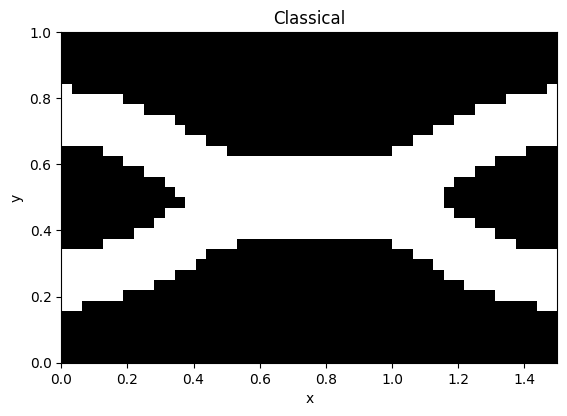

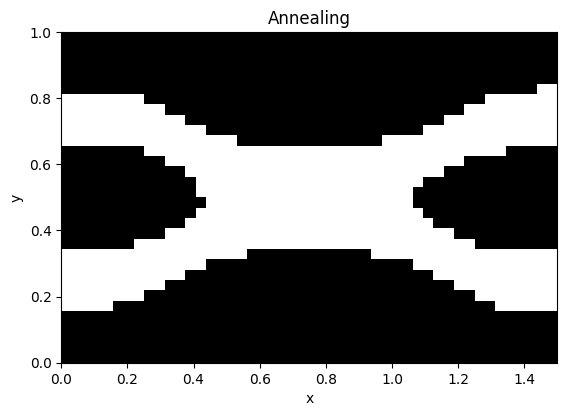

In [ ]:

file_name = None
tikz = True
title = 'Classical'
file_name = os.path.join(output_path, 'final_design_classical')
mesh_v.plot_element_quantity(binary_array, cmap='gray', cbar=False, title=title, file_name=file_name, tikz=tikz)
file_name = os.path.join(output_path, 'final_design_annealing')
title = 'Annealing'
mesh_v.plot_element_quantity(char_func, cmap='gray', cbar=False, title=title, file_name=file_name, tikz=tikz)